# 旅行者困境

## 导包

In [1]:
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt
import math

## 博弈游戏  
通过传递两个二维数组/列表来创建双向矩阵游戏，每一对数表示该玩家选择该行（列）选择所获得的分数：  
（2，2） （4，0） （4，0）  
（0，4） （3，3） （5，1）  
（0，4） （1，5） （4，4）

In [2]:
td = (np.array([[2,4,4],
               [0,3,5],
               [0,1,4]]),
     np.array([[2,0,0],
              [4,3,1],
              [4,5,4]]))
game = nash.Game(*td)
# list(game.equilibria())
list(game.support_enumeration())

[(array([1., 0., 0.]), array([1., 0., 0.]))]

这里[1, 0, 0]表示概率向量，表示玩家应该玩给定策略的概率。因此，在这种情况下，两个玩家都应该选择他们的第一选择，这将给我们得分2 ，2。之所以称其为纳什均衡，是因为在此位置，两个玩家都没有理由偏离（如果他们这样做，他们的得分就会下降，例如A选择第2行选项，则B会选择第1列选项导致A得分为0，而B得分为4）。

Rock\Paper\Scissors\Lizard\Spock  
(0,0) (-1,1) (1,-1) (1,-1) (-1,1)  
(1,-1) (0,0) (-1,1) (-1,1) (1,-1)  
(-1,1) (1,-1) (0,0) (1,-1) (-1,1)  
(-1,1) (1,-1) (-1,1) (0,0) (1,-1)  
(1,-1) (-1,1) (1,-1) (-1,1) (0,0)

In [3]:
rpsls = np.array([[0,-1,1,1,-1],
                 [1,0,-1,-1,1],
                 [-1,1,0,1,-1],
                 [-1,1,-1,0,1],
                 [1,-1,1,-1,0]])
# 另一个矩阵与该矩阵的正负恰好相反，因此直接加负号后拼接在一起
rpsls = (rpsls,-rpsls)
game = nash.Game(*rpsls)
list(game.support_enumeration())

[(array([0.2, 0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2, 0.2]))]

我们可以看到，两个玩家都应该随机完美地玩：以正好1/5的概率玩每个选项。这一切都是公平和良好的，纳什均衡在博弈论中是一个非常强大且重要的解决方案

## python实现博弈过程

### 获得随机选择

In [4]:
# 默认大小为10
def get_population(number_of_strategies,size=10):
    population = np.random.randint(0,number_of_strategies,size)
    return population

### 定义游戏

| |        |  B     |        |  
|-|--------|--------|--------|  
| |（2，2）|（4，0）|（4，0）|  
|A|（0，4）|（3，3）|（5，1）|  
| |（0，4）|（1，5）|（4，4）|  

In [5]:
td = (np.array([[2,4,4],
               [0,3,5],
               [0,1,4]]),
     np.array([[2,0,0],
              [4,3,1],
              [4,5,4]]))

In [6]:
rpsls = np.array([[0,-1,1,1,-1],
                 [1,0,-1,-1,1],
                 [-1,1,0,1,-1],
                 [-1,1,-1,0,1],
                 [1,-1,1,-1,0]])
rpsls = (rpsls,-rpsls)

### 定义得分

In [7]:
def get_scores(population,opponents,game):
    return[(game[0][i,j],game[1][i,j])
          for i,j in zip(population,opponents)]

### 博弈

In [8]:
# 初始化角色A选择（随机行）
np.random.seed(0)
population = get_population(3,10)
population

array([0, 1, 0, 1, 1, 2, 0, 2, 0, 0])

In [9]:
# 初始化对手B选择（随机列）
opponents = get_population(3,10)
opponents

array([0, 2, 1, 2, 2, 0, 1, 1, 1, 1])

In [10]:
# 计算A、B的得分矩阵（根据游戏td）
scores = get_scores(population,opponents,td)
scores

[(2, 2),
 (5, 1),
 (4, 0),
 (5, 1),
 (5, 1),
 (0, 4),
 (4, 0),
 (1, 5),
 (4, 0),
 (4, 0)]

In [11]:
# 更新策略
def mutate(scores,population,opponents):
    mutated_population = []
    for score,strategy_pair in zip(scores,zip(population,opponents)):
        if score[1] >= score[0]:
#             若A得分小于等于B，则将B的选择（第几列）添加到mutated_population
            mutated_population.append(strategy_pair[1])
        else:
#             若A得分大于于B，则将A的选择（第几行）添加到mutated_population
            mutated_population.append(strategy_pair[0])
    return np.array(mutated_population)

In [12]:
mutate(scores,population,opponents)

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [13]:
def evolve(game,size,generations):
    population = get_population(len(game[0]),size)
    opponents = get_population(len(game[0]),size)
    
    history = [population]
    
    for i in range(generations):
#         初始化得分矩阵
        scores = get_scores(population,opponents,game)
#         更新策略
        population = mutate(scores,population,opponents)
#         更新对手的随机选择
        opponents = get_population(len(game[0]),size)
#         将更新的策略加入历史记录
        history.append(population)
        
    return history

In [14]:
def zeroArray(I,J):
    m = []
    for i in range(I):
        fill = 0
        m.append([fill]*J)
    return m

[[7, 8, 5], [11, 6, 3], [14, 6, 0], [19, 1, 0], [19, 1, 0], [19, 1, 0], [19, 1, 0], [19, 1, 0], [20, 0, 0], [20, 0, 0], [20, 0, 0]]


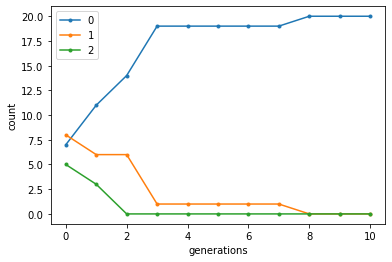

In [15]:
if __name__ == '__main__':
#     定义迭代次数
    generations = 11
#     定义游戏类型
    game = td
#     定义每一代游戏的选择次数
    count = 20
    
    np.random.seed(0)
    history = evolve(game,count,generations)
    num = game[0].shape[0]
    num_pic = zeroArray(generations,num)
    for i in range(generations):
        for j in history[i]:
            num_pic[i][j] += 1
    plt.xlabel("generations")
    plt.ylabel("count")
    print(num_pic)
#     print(len(num_pic))
#     plt.plot(num_pic,marker=".")
    plt.xlabel("generations")
    plt.ylabel("count")
#     plt.plot(num_pic,marker=".")
    num_count = zeroArray(num,generations)
    for i in range(generations):
        for j in range(num):
            num_count[j][i] = num_pic[i][j]
#     plt.plot(num_count[0],label='0')
#     plt.plot(num_count[1],label='1')
#     plt.plot(num_count[2],label='2')
    for i in range(num):
        plt.plot(num_count[i],marker='.',label=i)
    plt.legend()
#     plt.grid()
    plt.show()

### 为图像添加注释

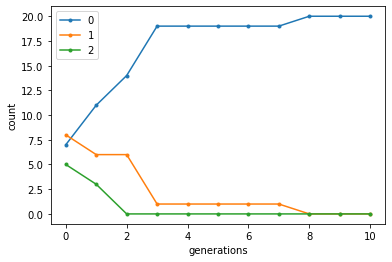

In [16]:
if __name__ == '__main__':
#     定义迭代次数
    generations = 11
#     定义游戏类型
    game = td
#     定义每一代游戏的选择次数
    count = 20
    
    np.random.seed(0)
    history = evolve(game,count,generations)
#     print(history)
    num = game[0].shape[0]
    num_pic = zeroArray(generations,num)
    for i in range(generations):
        for j in history[i]:
            num_pic[i][j] += 1
    plt.xlabel("generations")
    plt.ylabel("count")
#     plt.plot(num_pic,marker=".")
    num_count = zeroArray(num,generations)
    for i in range(generations):
        for j in range(num):
            num_count[j][i] = num_pic[i][j]
#     plt.plot(num_count[0],label='0')
#     plt.plot(num_count[1],label='1')
#     plt.plot(num_count[2],label='2')
    for i in range(num):
        plt.plot(num_count[i],marker='.',label=i)
    plt.legend()
#     plt.grid()
    plt.show()

### 不同种子下的图像

In [17]:
def drawpic(k,generations,game,count):
    np.random.seed(k)
    history = evolve(game,count,generations)
    num = game[0].shape[0]
    num_pic = zeroArray(generations,num)
    for i in range(generations):
        for j in history[i]:
            num_pic[i][j] += 1
    num_count = zeroArray(num,generations)
    for i in range(generations):
        for j in range(num):
            num_count[j][i] = num_pic[i][j]
    for i in range(num):
        plt.plot(num_count[i],label=i)
        plt.legend()

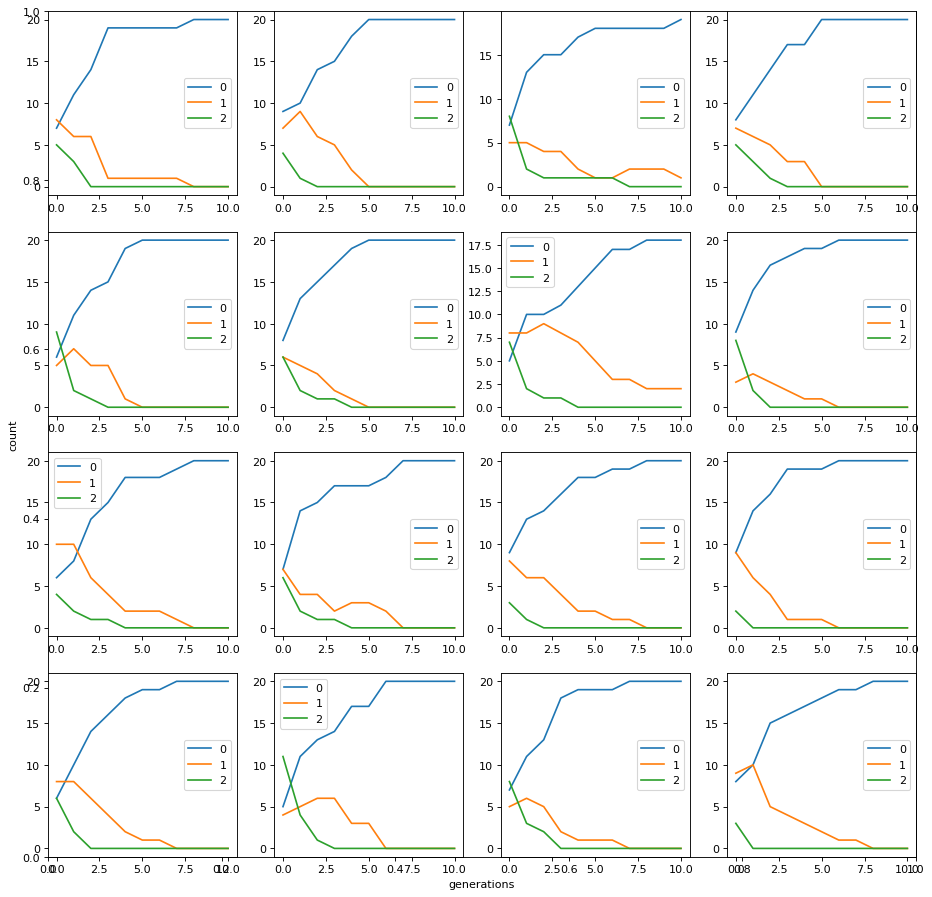

In [18]:
if __name__ == "__main__":
    seed=16
    
    p = plt.figure(figsize=(14,14),dpi=80)
    plt.xlabel("generations")
    plt.ylabel("count")
    for k in range(seed):
        ax = p.add_subplot(int(math.sqrt(seed)),int(math.sqrt(seed)),k+1)
        drawpic(k,11,td,20)

### 更改游戏

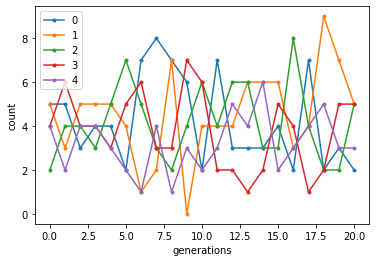

In [19]:
if __name__ == '__main__':
    generations = 21
#     更改游戏类型为rpsls
    game = rpsls
    count = 20
    
    np.random.seed(0)
    history = evolve(game,count,generations)
    num = game[0].shape[0]
    num_pic = zeroArray(generations,num)
    for i in range(generations):
        for j in history[i]:
            num_pic[i][j] += 1
    plt.xlabel("generations")
    plt.ylabel("count")
#     plt.plot(num_pic,marker=".")
    num_count = zeroArray(num,generations)
    for i in range(generations):
        for j in range(num):
            num_count[j][i] = num_pic[i][j]
#     plt.plot(num_count[0],label='0')
#     plt.plot(num_count[1],label='1')
#     plt.plot(num_count[2],label='2')
    for i in range(num):
        plt.plot(num_count[i],marker='.',label=i)
    plt.legend()
#     plt.grid()
    plt.show()

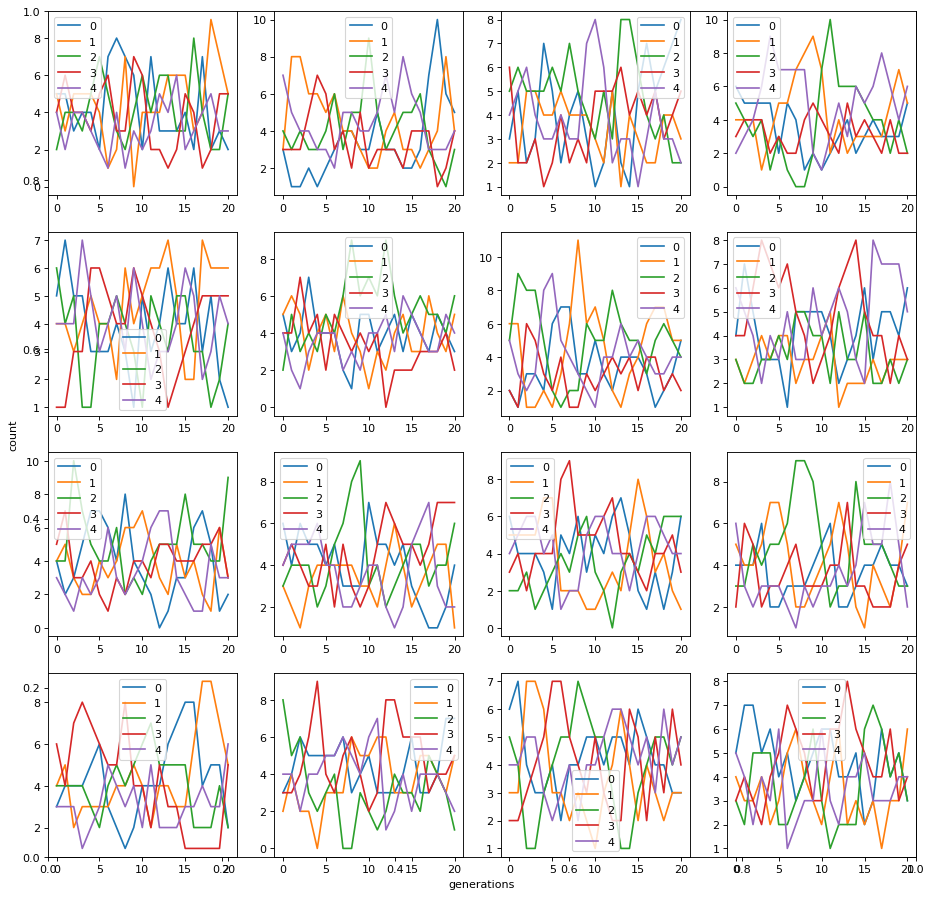

In [20]:
if __name__ == "__main__":
    seed=16
    
    p = plt.figure(figsize=(14,14),dpi=80)
    plt.xlabel("generations")
    plt.ylabel("count")
    for k in range(seed):
        ax = p.add_subplot(int(math.sqrt(seed)),int(math.sqrt(seed)),k+1)
        drawpic(k,21,rpsls,20)

## 附录（plt.plot?）

In [21]:
# plt.plot?

=============    ===============================  
character        description  
=============    ===============================  
``'.'``          point marker  
``','``          pixel marker  
``'o'``          circle marker  
``'v'``          triangle_down marker  
``'^'``          triangle_up marker  
``'<'``          triangle_left marker  
``'>'``          triangle_right marker  
``'1'``          tri_down marker  
``'2'``          tri_up marker  
``'3'``          tri_left marker  
``'4'``          tri_right marker  
``'s'``          square marker  
``'p'``          pentagon marker  
``'*'``          star marker  
``'h'``          hexagon1 marker  
``'H'``          hexagon2 marker  
``'+'``          plus marker  
``'x'``          x marker  
``'D'``          diamond marker  
``'d'``          thin_diamond marker  
``'|'``          vline marker  
``'_'``          hline marker  
=============    ===============================

参考文献： https://vknight.org/unpeudemath/mathematics/2017/03/08/simple-evolutionary-process.html  
NashPy： https://github.com/drvinceknight/Nashpy/tree/v0.0.17